In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
import gc
import os
from IPython.display import display
pd.options.display.max_columns = None
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
import time
import lightgbm as lgb

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt 
import seaborn as sns 
from collections import Counter

#import xlearn

/Users/jincui/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
df_train = pd.read_hdf('Elo_fe.h5', 'df_train')
df_test = pd.read_hdf('Elo_fe.h5', 'df_test')
target = pd.read_hdf('Elo_fe.h5', 'target')

In [3]:
id_test = pd.read_hdf('Elo_fe.h5', 'card_id')

In [66]:
#df_train = df_train[feature_importance_index]
#df_test = df_test[feature_importance_index]

/Users/jincui/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/jincui/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/jincui/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/jincui/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwa

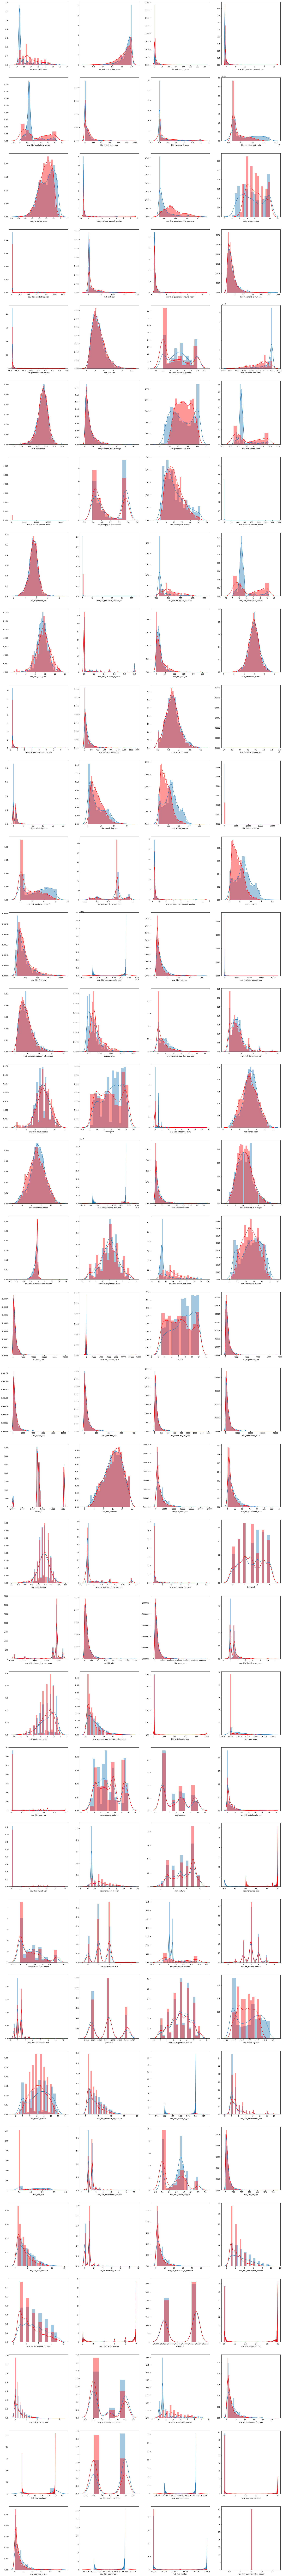

In [65]:
plt.figure(figsize=(30,300))
count = 1
for col in df_train.columns:
    if df_train[col].dtypes in [int, float]:
        
        x = df_train[col][~np.isnan(df_train[col])]
        y = df_train[target==-33.21928095][col][~np.isnan(df_train[target==-33.21928095][col])]
        
        np.random.seed(0)
        x_s = np.random.choice(x, len(y))
        
        plt.subplot(35, 4, count)
        sns.distplot(x_s, label=col)
        sns.distplot(y, color='r')
        count +=1
    else:
        pass

In [4]:
outliers = target.copy()
outliers[target>= -30] = 0
outliers[target< -30] = 1
outliers.values

array([0., 0., 0., ..., 0., 0., 0.])

In [5]:
outliers = target.copy()
outliers[target>= -30] = 0
outliers[target< -30] = 1

def KFoldscore(param):

    folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
        
    oof = np.zeros(len(df_train))
    predictions = np.zeros(len(df_test))
    feature_importance_df = pd.DataFrame()
    df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month','target','outliers']]
    mfull = np.zeros(len(df_test))

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train, outliers.values)):
        print("fold {}".format(fold_))
        trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
        val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

        num_round = 10000
        clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
        oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["Feature"] = df_train_columns
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits
        mfull += clf.predict(df_test, 
                             num_iteration=clf.best_iteration) / folds.n_splits
    
    score = np.sqrt(mean_squared_error(oof, target))
    print('score: {}'.format(score))
    return mfull

In [86]:
# current run with StratifiedKFold makes rmse score more stable in each fold!!!
param = {'num_leaves': 63,
         'min_data_in_leaf': 30,
         'objective': 'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.7,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 12,
         "metric": 'rmse',
         "reg_lambda": 1,
         'reg_alpha': 1,
         "verbosity": -1,
         "nthread": -1,
         "random_state": 1
         }

mfull = KFoldscore(param)

fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.70194	valid_1's rmse: 3.76621
[200]	training's rmse: 3.61251	valid_1's rmse: 3.73327
[300]	training's rmse: 3.54872	valid_1's rmse: 3.72035
[400]	training's rmse: 3.50023	valid_1's rmse: 3.71406
[500]	training's rmse: 3.46169	valid_1's rmse: 3.71023
[600]	training's rmse: 3.42927	valid_1's rmse: 3.70806
[700]	training's rmse: 3.40058	valid_1's rmse: 3.70669
[800]	training's rmse: 3.37527	valid_1's rmse: 3.70533
[900]	training's rmse: 3.35235	valid_1's rmse: 3.70336
[1000]	training's rmse: 3.33104	valid_1's rmse: 3.70176
[1100]	training's rmse: 3.3118	valid_1's rmse: 3.70052
[1200]	training's rmse: 3.29317	valid_1's rmse: 3.70011
[1300]	training's rmse: 3.27566	valid_1's rmse: 3.69933
[1400]	training's rmse: 3.25902	valid_1's rmse: 3.69927
[1500]	training's rmse: 3.24296	valid_1's rmse: 3.69899
[1600]	training's rmse: 3.22769	valid_1's rmse: 3.69897
Early stopping, best iteration is:
[1524]	tr

[500]	training's rmse: 3.47049	valid_1's rmse: 3.66104
[600]	training's rmse: 3.43853	valid_1's rmse: 3.65563
[700]	training's rmse: 3.41042	valid_1's rmse: 3.65123
[800]	training's rmse: 3.38516	valid_1's rmse: 3.64833
[900]	training's rmse: 3.36271	valid_1's rmse: 3.64557
[1000]	training's rmse: 3.34163	valid_1's rmse: 3.64378
[1100]	training's rmse: 3.32125	valid_1's rmse: 3.64219
[1200]	training's rmse: 3.30254	valid_1's rmse: 3.64135
[1300]	training's rmse: 3.28408	valid_1's rmse: 3.641
[1400]	training's rmse: 3.26727	valid_1's rmse: 3.64014
[1500]	training's rmse: 3.25104	valid_1's rmse: 3.6397
[1600]	training's rmse: 3.23547	valid_1's rmse: 3.63944
[1700]	training's rmse: 3.22058	valid_1's rmse: 3.63888
[1800]	training's rmse: 3.20588	valid_1's rmse: 3.63839
[1900]	training's rmse: 3.19232	valid_1's rmse: 3.63835
[2000]	training's rmse: 3.17904	valid_1's rmse: 3.63759
[2100]	training's rmse: 3.16534	valid_1's rmse: 3.63777
Early stopping, best iteration is:
[2010]	training's rms

In [89]:
df_test.shape

(123623, 136)

In [93]:
xsub = pd.DataFrame()
xsub['card_id']  = id_test
xsub['target'] = mfull
xsub.to_csv('submission1.csv', index = False)

In [79]:
## previous run with KFold
param = {'num_leaves': 63,
         'min_data_in_leaf': 30,
         'objective': 'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.7,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 12,
         "metric": 'rmse',
         "reg_lambda": 1,
         'reg_alpha': 1,
         "verbosity": -1,
         "nthread": -1,
         "random_state": 1
         }

mfull = KFoldscore(param)

fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.70528	valid_1's rmse: 3.76324
[200]	training's rmse: 3.6187	valid_1's rmse: 3.71438
[300]	training's rmse: 3.55658	valid_1's rmse: 3.6905
[400]	training's rmse: 3.50815	valid_1's rmse: 3.6784
[500]	training's rmse: 3.47106	valid_1's rmse: 3.67141
[600]	training's rmse: 3.43822	valid_1's rmse: 3.66782
[700]	training's rmse: 3.41017	valid_1's rmse: 3.66503
[800]	training's rmse: 3.38572	valid_1's rmse: 3.66361
[900]	training's rmse: 3.36183	valid_1's rmse: 3.66197
[1000]	training's rmse: 3.34114	valid_1's rmse: 3.66066
[1100]	training's rmse: 3.32156	valid_1's rmse: 3.65976
[1200]	training's rmse: 3.30278	valid_1's rmse: 3.65928
[1300]	training's rmse: 3.28489	valid_1's rmse: 3.65877
[1400]	training's rmse: 3.2681	valid_1's rmse: 3.65855
[1500]	training's rmse: 3.25177	valid_1's rmse: 3.65804
[1600]	training's rmse: 3.23618	valid_1's rmse: 3.65755
[1700]	training's rmse: 3.22144	valid_1's rmse:

[2700]	training's rmse: 3.0888	valid_1's rmse: 3.70782
[2800]	training's rmse: 3.07768	valid_1's rmse: 3.7076
[2900]	training's rmse: 3.06645	valid_1's rmse: 3.70731
[3000]	training's rmse: 3.05542	valid_1's rmse: 3.70729
Early stopping, best iteration is:
[2935]	training's rmse: 3.06248	valid_1's rmse: 3.70718
fold 7
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.71827	valid_1's rmse: 3.62736
[200]	training's rmse: 3.62973	valid_1's rmse: 3.58882
[300]	training's rmse: 3.56707	valid_1's rmse: 3.57176
[400]	training's rmse: 3.5186	valid_1's rmse: 3.56355
[500]	training's rmse: 3.47983	valid_1's rmse: 3.55817
[600]	training's rmse: 3.44707	valid_1's rmse: 3.55563
[700]	training's rmse: 3.41932	valid_1's rmse: 3.55352
[800]	training's rmse: 3.39436	valid_1's rmse: 3.55212
[900]	training's rmse: 3.3716	valid_1's rmse: 3.55056
[1000]	training's rmse: 3.35061	valid_1's rmse: 3.5493
[1100]	training's rmse: 3.33014	valid_1's rmse: 3.54866
[1200]	traini

In [6]:
##
df_train.head()

,hist_month_diff_mean,hist_authorized_flag_mean,hist_category_1_sum,new_hist_purchase_amount_max,new_hist_weekofyear_mean,hist_installments_sum,hist_category_1_mean,hist_purchase_date_min,hist_month_lag_mean,hist_purchase_amount_median,new_hist_purchase_date_uptonow,hist_month_nunique,new_hist_weekofyear_var,hist_first_buy,new_hist_purchase_amount_mean,hist_merchant_id_nunique,hist_purchase_amount_min,hist_hour_var,new_hist_month_lag_mean,hist_purchase_date_max,hist_hour_mean,hist_purchase_date_average,hist_purchase_date_diff,new_hist_month_mean,hist_purchase_amount_max,hist_category_3_mean_mean,hist_weekofyear_nunique,hist_purchase_amount_mean,hist_dayofweek_var,new_hist_purchase_amount_var,hist_purchase_date_uptonow,new_hist_weekofyear_median,new_hist_hour_mean,new_hist_category_1_mean,new_hist_hour_var,hist_dayofweek_mean,new_hist_purchase_amount_min,new_hist_weekofyear_sum,hist_weekend_mean,hist_purchase_amount_var,hist_installments_mean,hist_month_lag_var,hist_weekofyear_var,hist_installments_var,new_hist_purchase_date_diff,hist_category_2_mean_mean,new_hist_purchase_amount_median,hist_month_var,new_hist_first_buy,new_hist_purchase_date_max,new_hist_hour_sum,hist_purchase_amount_sum,hist_merchant_category_id_nunique,elapsed_time,new_hist_purchase_date_average,new_hist_dayofweek_var,new_hist_hour_median,weekofyear,new_hist_category_1_sum,hist_month_mean,hist_weekofyear_mean,new_hist_purchase_date_min,new_hist_month_sum,hist_subsector_id_nunique,new_hist_purchase_amount_sum,new_hist_dayofweek_mean,new_hist_month_diff_mean,hist_weekofyear_median,hist_hour_sum,purchase_amount_total,month,hist_dayofweek_sum,hist_month_sum,hist_weekend_sum,hist_authorized_flag_sum,hist_weekofyear_sum,feature_1,hist_hour_nunique,new_hist_year_sum,new_hist_dayofweek_sum,hist_hour_median,new_hist_category_3_mean_mean,new_hist_installments_var,dayofweek,new_hist_category_2_mean_mean,card_id_total,hist_year_sum,new_hist_installments_mean,hist_month_lag_median,new_hist_merchant_category_id_nunique,hist_installments_max,hist_year_mean,new_hist_year_var,sumofsquare_features,dot_features,new_hist_installments_sum,new_hist_month_var,hist_month_diff_median,sum_features,hist_month_lag_max,new_hist_weekend_mean,hist_installments_min,new_hist_month_median,hist_dayofweek_median,new_hist_installments_min,feature_2,new_hist_dayofweek_median,hist_month_lag_min,hist_month_median,new_hist_subsector_id_nunique,new_hist_month_lag_max,new_hist_installments_max,hist_year_var,new_hist_installments_median,new_hist_month_lag_var,hist_card_id_size,new_hist_hour_nunique,hist_installments_median,new_hist_merchant_id_nunique,new_hist_weekofyear_nunique,new_hist_dayofweek_nunique,hist_dayofweek_nunique,feature_3,new_hist_month_lag_min,new_hist_weekend_sum,new_hist_month_lag_median,new_hist_month_diff_median,new_hist_authorized_flag_sum,hist_year_nunique,new_hist_month_nunique,new_hist_year_mean,new_hist_year_nunique,new_hist_card_id_size,new_hist_year_median,hist_year_median,new_hist_authorized_flag_mean
0,10.757692,0.950000,0,-0.296112,13.304348,4,0.000000,1.498573e+09,-3.911538,-0.698042,263.0,9,5.312253,26,-0.575835,94,-0.739395,24.687793,1.478261,1.519551e+09,13.315385,0.930769,242,3.478261,2.258395,0.346719,35,-0.638341,3.912608,0.018445,326,13.0,12.869565,0.000000,4.209486,3.211538,-0.724368,306.0,0.346154,0.045003,0.015385,5.748901,231.033249,0.015206,54.0,0.072502,-0.581180,12.070018,277.0,1.525001e+09,296.0,-165.968739,41,595,2.347826,4.118577,13.0,22,0.0,8.057692,33.073077,1.520259e+09,80.0,21,-13.244202,3.130435,10.695652,34.0,3462,-179.212942,6,835,2095,90,247,8599,0.013145,23,46414.0,72.0,14.0,-0.592993,0.000000,3,-0.550160,283.0,524464,0.000000,-4.0,14.0,1,2017.169231,0.0,30,10,0.0,0.260870,11.0,8,0,0.260870,0,3.0,3.0,0.0,0.008752,4.0,-8,8.0,10.0,2.0,0.0,0.141135,0.0,0.260870,260,8.0,0.0,23.0,7.0,7.0,7,0.011428,1.0,6.0,1.0,11.0,23.0,2,2.0,2018.0,1.0,23.0,2018.0,2017.0,1.0
1,11.765714,0.968571,31,-0.701858,9.000000,543,0.088571,1.483720e+09,-5.031429,-0.708590,29

In [13]:
list(df_train.columns)

['hist_month_diff_mean',
 'hist_authorized_flag_mean',
 'hist_category_1_sum',
 'new_hist_purchase_amount_max',
 'new_hist_weekofyear_mean',
 'hist_installments_sum',
 'hist_category_1_mean',
 'hist_purchase_date_min',
 'hist_month_lag_mean',
 'hist_purchase_amount_median',
 'new_hist_purchase_date_uptonow',
 'hist_month_nunique',
 'new_hist_weekofyear_var',
 'hist_first_buy',
 'new_hist_purchase_amount_mean',
 'hist_merchant_id_nunique',
 'hist_purchase_amount_min',
 'hist_hour_var',
 'new_hist_month_lag_mean',
 'hist_purchase_date_max',
 'hist_hour_mean',
 'hist_purchase_date_average',
 'hist_purchase_date_diff',
 'new_hist_month_mean',
 'hist_purchase_amount_max',
 'hist_category_3_mean_mean',
 'hist_weekofyear_nunique',
 'hist_purchase_amount_mean',
 'hist_dayofweek_var',
 'new_hist_purchase_amount_var',
 'hist_purchase_date_uptonow',
 'new_hist_weekofyear_median',
 'new_hist_hour_mean',
 'new_hist_category_1_mean',
 'new_hist_hour_var',
 'hist_dayofweek_mean',
 'new_hist_purchase_

In [12]:
df_train['feature_2']

0         0.008752
1         0.011385
2         0.008752
3         0.014166
4         0.014166
5         0.008752
6         0.008752
7         0.008752
8         0.011385
9         0.008752
10        0.008752
11        0.008752
12        0.008752
13        0.011385
14        0.008752
15        0.011385
16        0.008752
17        0.008752
18        0.011385
19        0.011385
20        0.008752
21        0.008752
22        0.008752
23        0.008752
24        0.011385
25        0.008752
26        0.014166
27        0.014166
28        0.011385
29        0.008752
            ...   
201887    0.008752
201888    0.008752
201889    0.008752
201890    0.008752
201891    0.008752
201892    0.014166
201893    0.011385
201894    0.008752
201895    0.011385
201896    0.014166
201897    0.008752
201898    0.011385
201899    0.011385
201900    0.008752
201901    0.008752
201902    0.014166
201903    0.008752
201904    0.014166
201905    0.008752
201906    0.008752
201907    0.011385
201908    0.

In [15]:
def add_sq_sqrt_lg(df):
    for col in df.columns:
        col_sq = col + '_square'
        col_sqrt = col + '_sqrt'
        col_lg = col + '_lg'
        
        df[col_sq] = df[col]**2
        df[col_sqrt] = df[col] ** (0.5)
        df[col_lg] = np.log(df[col])
    

In [16]:
add_sq_sqrt_lg(df_train)
add_sq_sqrt_lg(df_test)

/Users/jincui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/Users/jincui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


In [18]:
param = {'num_leaves': 63,
         'min_data_in_leaf': 30,
         'objective': 'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.7,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 12,
         "metric": 'rmse',
         "reg_lambda": 1,
         'reg_alpha': 1,
         "verbosity": -1,
         "nthread": -1,
         "random_state": 1
         }

mfull = KFoldscore(param)

fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.69856	valid_1's rmse: 3.76796
[200]	training's rmse: 3.6062	valid_1's rmse: 3.73707
[300]	training's rmse: 3.54056	valid_1's rmse: 3.724
[400]	training's rmse: 3.491	valid_1's rmse: 3.71844
[500]	training's rmse: 3.45135	valid_1's rmse: 3.71329
[600]	training's rmse: 3.41843	valid_1's rmse: 3.71054
[700]	training's rmse: 3.38965	valid_1's rmse: 3.70841
[800]	training's rmse: 3.36414	valid_1's rmse: 3.70668
[900]	training's rmse: 3.34084	valid_1's rmse: 3.70537
[1000]	training's rmse: 3.31875	valid_1's rmse: 3.70414
[1100]	training's rmse: 3.29844	valid_1's rmse: 3.70318
[1200]	training's rmse: 3.2786	valid_1's rmse: 3.70271
[1300]	training's rmse: 3.26015	valid_1's rmse: 3.70194
[1400]	training's rmse: 3.24351	valid_1's rmse: 3.70161
[1500]	training's rmse: 3.22698	valid_1's rmse: 3.70099
[1600]	training's rmse: 3.21093	valid_1's rmse: 3.70086
[1700]	training's rmse: 3.19592	valid_1's rmse: 3

[900]	training's rmse: 3.34957	valid_1's rmse: 3.64642
[1000]	training's rmse: 3.32683	valid_1's rmse: 3.64509
[1100]	training's rmse: 3.30576	valid_1's rmse: 3.64346
[1200]	training's rmse: 3.28678	valid_1's rmse: 3.64242
[1300]	training's rmse: 3.26803	valid_1's rmse: 3.64177
[1400]	training's rmse: 3.25084	valid_1's rmse: 3.64146
[1500]	training's rmse: 3.23378	valid_1's rmse: 3.64123
[1600]	training's rmse: 3.21736	valid_1's rmse: 3.64108
Early stopping, best iteration is:
[1565]	training's rmse: 3.22323	valid_1's rmse: 3.64091
fold 8
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.70557	valid_1's rmse: 3.73096
[200]	training's rmse: 3.61607	valid_1's rmse: 3.67852
[300]	training's rmse: 3.55297	valid_1's rmse: 3.65039
[400]	training's rmse: 3.50431	valid_1's rmse: 3.63741
[500]	training's rmse: 3.46507	valid_1's rmse: 3.62716
[600]	training's rmse: 3.43228	valid_1's rmse: 3.62065
[700]	training's rmse: 3.40258	valid_1's rmse: 3.61638
[800]	t

In [19]:
xsub = pd.DataFrame()
xsub['card_id']  = id_test
xsub['target'] = mfull
xsub.to_csv('submission1.csv', index = False)

In [20]:
mfull_list = []

In [21]:
param = {'num_leaves': 80,
         'min_data_in_leaf': 100,
         'objective': 'regression',
         'max_depth': -1,
         'learning_rate': 0.002,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.5,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 12,
         "metric": 'rmse',
         "reg_lambda": 1,
         'reg_alpha': 1,
         "verbosity": -1,
         "nthread": -1,
         "random_state": 1
         }

mfull_list.append(KFoldscore(param))

fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.78214	valid_1's rmse: 3.80484
[200]	training's rmse: 3.73018	valid_1's rmse: 3.77227
[300]	training's rmse: 3.68955	valid_1's rmse: 3.75002
[400]	training's rmse: 3.65685	valid_1's rmse: 3.73533
[500]	training's rmse: 3.62895	valid_1's rmse: 3.72512
[600]	training's rmse: 3.6047	valid_1's rmse: 3.7183
[700]	training's rmse: 3.58337	valid_1's rmse: 3.71381
[800]	training's rmse: 3.56408	valid_1's rmse: 3.71064
[900]	training's rmse: 3.54662	valid_1's rmse: 3.70839
[1000]	training's rmse: 3.53117	valid_1's rmse: 3.70653
[1100]	training's rmse: 3.5164	valid_1's rmse: 3.70553
[1200]	training's rmse: 3.50324	valid_1's rmse: 3.70419
[1300]	training's rmse: 3.49084	valid_1's rmse: 3.70319
[1400]	training's rmse: 3.4794	valid_1's rmse: 3.7022
[1500]	training's rmse: 3.46868	valid_1's rmse: 3.70143
[1600]	training's rmse: 3.45835	valid_1's rmse: 3.70059
[1700]	training's rmse: 3.44881	valid_1's rmse: 

fold 4
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.78196	valid_1's rmse: 3.81446
[200]	training's rmse: 3.73086	valid_1's rmse: 3.77917
[300]	training's rmse: 3.69091	valid_1's rmse: 3.75402
[400]	training's rmse: 3.65864	valid_1's rmse: 3.73552
[500]	training's rmse: 3.63124	valid_1's rmse: 3.72158
[600]	training's rmse: 3.60741	valid_1's rmse: 3.71111
[700]	training's rmse: 3.58638	valid_1's rmse: 3.7032
[800]	training's rmse: 3.56737	valid_1's rmse: 3.6965
[900]	training's rmse: 3.55039	valid_1's rmse: 3.69158
[1000]	training's rmse: 3.53464	valid_1's rmse: 3.68729
[1100]	training's rmse: 3.52026	valid_1's rmse: 3.68392
[1200]	training's rmse: 3.50722	valid_1's rmse: 3.68105
[1300]	training's rmse: 3.49516	valid_1's rmse: 3.6783
[1400]	training's rmse: 3.4838	valid_1's rmse: 3.67596
[1500]	training's rmse: 3.47277	valid_1's rmse: 3.67377
[1600]	training's rmse: 3.46257	valid_1's rmse: 3.67172
[1700]	training's rmse: 3.45286	valid_1's rmse:

[1100]	training's rmse: 3.52683	valid_1's rmse: 3.62672
[1200]	training's rmse: 3.51385	valid_1's rmse: 3.62316
[1300]	training's rmse: 3.50167	valid_1's rmse: 3.62034
[1400]	training's rmse: 3.49	valid_1's rmse: 3.61809
[1500]	training's rmse: 3.47915	valid_1's rmse: 3.61602
[1600]	training's rmse: 3.46871	valid_1's rmse: 3.61418
[1700]	training's rmse: 3.45881	valid_1's rmse: 3.61264
[1800]	training's rmse: 3.4495	valid_1's rmse: 3.61139
[1900]	training's rmse: 3.44047	valid_1's rmse: 3.6101
[2000]	training's rmse: 3.43187	valid_1's rmse: 3.6093
[2100]	training's rmse: 3.42332	valid_1's rmse: 3.60843
[2200]	training's rmse: 3.41495	valid_1's rmse: 3.60753
[2300]	training's rmse: 3.40707	valid_1's rmse: 3.60686
[2400]	training's rmse: 3.39926	valid_1's rmse: 3.60615
[2500]	training's rmse: 3.39169	valid_1's rmse: 3.60559
[2600]	training's rmse: 3.38418	valid_1's rmse: 3.6049
[2700]	training's rmse: 3.37698	valid_1's rmse: 3.60451
[2800]	training's rmse: 3.37014	valid_1's rmse: 3.60407

In [22]:
param = {'num_leaves': 80,
         'min_data_in_leaf': 100,
         'objective': 'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.5,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 12,
         "metric": 'rmse',
         "reg_lambda": 1,
         'reg_alpha': 1,
         "verbosity": -1,
         "nthread": -1,
         "random_state": 1
         }

mfull_list.append(KFoldscore(param))

fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.70865	valid_1's rmse: 3.75931
[200]	training's rmse: 3.62865	valid_1's rmse: 3.72401
[300]	training's rmse: 3.57331	valid_1's rmse: 3.7105
[400]	training's rmse: 3.53197	valid_1's rmse: 3.70454
[500]	training's rmse: 3.49772	valid_1's rmse: 3.70084
[600]	training's rmse: 3.46995	valid_1's rmse: 3.69853
[700]	training's rmse: 3.44539	valid_1's rmse: 3.69673
[800]	training's rmse: 3.42335	valid_1's rmse: 3.69504
[900]	training's rmse: 3.40266	valid_1's rmse: 3.69348
[1000]	training's rmse: 3.38331	valid_1's rmse: 3.69252
[1100]	training's rmse: 3.36524	valid_1's rmse: 3.69169
[1200]	training's rmse: 3.34787	valid_1's rmse: 3.69059
[1300]	training's rmse: 3.33114	valid_1's rmse: 3.68987
[1400]	training's rmse: 3.31543	valid_1's rmse: 3.68922
[1500]	training's rmse: 3.29986	valid_1's rmse: 3.68914
Early stopping, best iteration is:
[1482]	training's rmse: 3.30258	valid_1's rmse: 3.68899
fold 1
Tr

[500]	training's rmse: 3.50842	valid_1's rmse: 3.62186
[600]	training's rmse: 3.47946	valid_1's rmse: 3.61619
[700]	training's rmse: 3.45475	valid_1's rmse: 3.61259
[800]	training's rmse: 3.43225	valid_1's rmse: 3.60962
[900]	training's rmse: 3.41184	valid_1's rmse: 3.60752
[1000]	training's rmse: 3.39251	valid_1's rmse: 3.60547
[1100]	training's rmse: 3.3741	valid_1's rmse: 3.60464
[1200]	training's rmse: 3.35652	valid_1's rmse: 3.60358
[1300]	training's rmse: 3.33976	valid_1's rmse: 3.60265
[1400]	training's rmse: 3.32389	valid_1's rmse: 3.60191
[1500]	training's rmse: 3.309	valid_1's rmse: 3.60128
[1600]	training's rmse: 3.29369	valid_1's rmse: 3.60066
Early stopping, best iteration is:
[1594]	training's rmse: 3.2946	valid_1's rmse: 3.60061
fold 9
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.71244	valid_1's rmse: 3.74387
[200]	training's rmse: 3.63521	valid_1's rmse: 3.69398
[300]	training's rmse: 3.58161	valid_1's rmse: 3.66963
[400]	train

In [23]:
param = {'num_leaves': 127,
         'min_data_in_leaf': 100,
         'objective': 'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.5,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 12,
         "metric": 'rmse',
         "reg_lambda": 1,
         'reg_alpha': 1,
         "verbosity": -1,
         "nthread": -1,
         "random_state": 1
         }

mfull_list.append(KFoldscore(param))

fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.69575	valid_1's rmse: 3.7564
[200]	training's rmse: 3.60545	valid_1's rmse: 3.72035
[300]	training's rmse: 3.54045	valid_1's rmse: 3.70684
[400]	training's rmse: 3.48931	valid_1's rmse: 3.70159
[500]	training's rmse: 3.44567	valid_1's rmse: 3.69928
[600]	training's rmse: 3.40849	valid_1's rmse: 3.69818
[700]	training's rmse: 3.37551	valid_1's rmse: 3.69669
[800]	training's rmse: 3.34566	valid_1's rmse: 3.6964
[900]	training's rmse: 3.31746	valid_1's rmse: 3.69532
[1000]	training's rmse: 3.2912	valid_1's rmse: 3.69498
[1100]	training's rmse: 3.26657	valid_1's rmse: 3.6943
[1200]	training's rmse: 3.24278	valid_1's rmse: 3.69437
Early stopping, best iteration is:
[1103]	training's rmse: 3.26585	valid_1's rmse: 3.69425
fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.69763	valid_1's rmse: 3.73633
[200]	training's rmse: 3.60823	valid_1's rmse: 3.69331


Early stopping, best iteration is:
[811]	training's rmse: 3.35024	valid_1's rmse: 3.64321
score: 3.6565947014736158


In [27]:
param = {'num_leaves': 80,
         'min_data_in_leaf': 200,
         'objective': 'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.5,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 12,
         "metric": 'rmse',
         "reg_lambda": 1,
         'reg_alpha': 1,
         "verbosity": -1,
         "nthread": -1,
         "random_state": 1
         }

mfull_list.append(KFoldscore(param))

fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.72078	valid_1's rmse: 3.75831
[200]	training's rmse: 3.65244	valid_1's rmse: 3.72123
[300]	training's rmse: 3.60697	valid_1's rmse: 3.70606
[400]	training's rmse: 3.57328	valid_1's rmse: 3.69909
[500]	training's rmse: 3.54576	valid_1's rmse: 3.69593
[600]	training's rmse: 3.52236	valid_1's rmse: 3.69339
[700]	training's rmse: 3.5019	valid_1's rmse: 3.69157
[800]	training's rmse: 3.48315	valid_1's rmse: 3.69053
[900]	training's rmse: 3.466	valid_1's rmse: 3.68949
[1000]	training's rmse: 3.44965	valid_1's rmse: 3.68895
[1100]	training's rmse: 3.43369	valid_1's rmse: 3.68826
[1200]	training's rmse: 3.41887	valid_1's rmse: 3.68814
Early stopping, best iteration is:
[1144]	training's rmse: 3.42701	valid_1's rmse: 3.68796
fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.72301	valid_1's rmse: 3.73892
[200]	training's rmse: 3.65572	valid_1's rmse: 3.69692

[600]	training's rmse: 3.5321	valid_1's rmse: 3.61791
[700]	training's rmse: 3.51194	valid_1's rmse: 3.6134
[800]	training's rmse: 3.49354	valid_1's rmse: 3.61109
[900]	training's rmse: 3.47625	valid_1's rmse: 3.60869
[1000]	training's rmse: 3.45985	valid_1's rmse: 3.60684
[1100]	training's rmse: 3.44448	valid_1's rmse: 3.60561
[1200]	training's rmse: 3.42936	valid_1's rmse: 3.60461
[1300]	training's rmse: 3.415	valid_1's rmse: 3.60343
[1400]	training's rmse: 3.401	valid_1's rmse: 3.60293
[1500]	training's rmse: 3.38784	valid_1's rmse: 3.60279
[1600]	training's rmse: 3.37468	valid_1's rmse: 3.60244
[1700]	training's rmse: 3.36183	valid_1's rmse: 3.60238
[1800]	training's rmse: 3.34931	valid_1's rmse: 3.60242
Early stopping, best iteration is:
[1744]	training's rmse: 3.35622	valid_1's rmse: 3.60224
fold 9
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.72396	valid_1's rmse: 3.74262
[200]	training's rmse: 3.65752	valid_1's rmse: 3.69253
[300]	train

In [30]:
len(mfull_list)

4

In [31]:
# LB 3.700
xsub = pd.DataFrame()
xsub['card_id']  = id_test
xsub['target'] = mfull_list[3]
xsub.to_csv('submission1.csv', index = False)

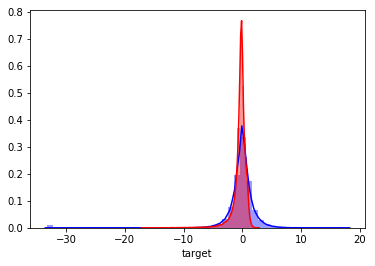

In [33]:
sns.distplot(target, color='b')
sns.distplot(mfull_list[3], color='r')

In [50]:
print(len(target[target<0]))
print(len(target[target<-1]))
print(len(target[target<-2]))
print(len(target[target<-3]))
print(len(target[target<-4]))

102678
45661
20813
10767
6248


In [52]:
print(len(target[target>=0]))
print(len(target[target>1]))
print(len(target[target>2]))
print(len(target[target>3]))
print(len(target[target>4]))

99239
40900
17573
8037
3717


In [67]:
print(target.mean())
print(target.std())
print(target.median())
print(target.skew())
print(target.kurtosis())

-0.39363629907797143
3.850499995486051
-0.02343689
-6.720159691530676
55.031783190452124


In [78]:
y1 = np.concatenate([target, np.repeat(0-target.min(), len(target[target<-30]))])
print(np.mean(y1))
print(np.std(y1))
print(np.median(y1))
print(skew(y1))
print(kurtosis(y1))

-0.030211575043992984
5.172007531531865
-0.00778289
0.01375080155064357
33.88934845084142


In [ ]:
y0 = np.random.normal()

In [28]:
param = {'num_leaves': 80,
         'min_data_in_leaf': 200,
         'objective': 'regression',
         'max_depth': -1,
         'learning_rate': 0.05,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.5,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 12,
         "metric": 'rmse',
         "reg_lambda": 2,
         'reg_alpha': 2,
         "verbosity": -1,
         "nthread": -1,
         "random_state": 1
         }

mfull_list.append(KFoldscore(param))

fold 0


KeyboardInterrupt: 

In [ ]:
param = {'num_leaves': 71,
         'min_data_in_leaf': 200,
         'objective': 'regression',
         'max_depth': -1,
         'learning_rate': 0.002,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.3,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 12,
         "metric": 'rmse',
         "reg_lambda": 1.5,
         'reg_alpha': 1.5,
         "verbosity": -1,
         "nthread": -1,
         "random_state": 1
         }

mfull_list.append(KFoldscore(param))

In [ ]:
param = {'num_leaves': 71,
         'min_data_in_leaf': 200,
         'objective': 'regression',
         'max_depth': -1,
         'learning_rate': 0.002,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.15,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 12,
         "metric": 'rmse',
         "reg_lambda": 1.5,
         'reg_alpha': 1.5,
         "verbosity": -1,
         "nthread": -1,
         "random_state": 1
         }

mfull_list.append(KFoldscore(param))

In [ ]:
param = {'num_leaves': 71,
         'min_data_in_leaf': 200,
         'objective': 'regression',
         'max_depth': -1,
         'learning_rate': 0.0002,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.5,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 12,
         "metric": 'rmse',
         "reg_lambda": 1,
         'reg_alpha': 1,
         "verbosity": -1,
         "nthread": -1,
         "random_state": 1
         }

mfull_list.append(KFoldscore(param))